## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2019-12-20 13:11:17--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.121.10
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  1.32MB/s    in 2m 16s  

2019-12-20 13:13:33 (2.38 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (conv1_drop): Dropout(p=0.1)
  (conv2_drop): Dropout(p=0.2)
  (conv3_drop): Dropout(p=0.3)
  (conv4_drop): Dropout(p=0.4)
  (conv5_drop): Dropout(p=0.5)
  (fc1_drop): Dropout(p=0.6)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    # custom normalization: intensity range: [0,1], keypoints: [-1,1]
    Normalize(),
    ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             # apply created transformer
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    # gt_pts - actual keypoints 
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

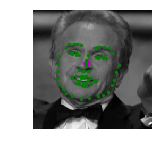

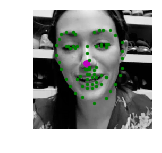

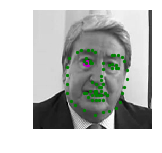

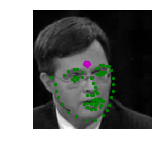

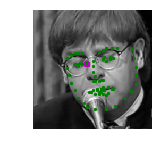

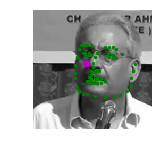

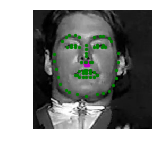

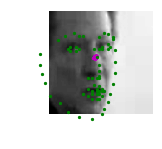

In [32]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=8):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [33]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [34]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

                
    print('Finished Training')


In [35]:
# train your network
n_epochs = 25 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    training_loss = train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.4375000521540642
Epoch: 1, Batch: 20, Avg. Loss: 0.2577717289328575
Epoch: 1, Batch: 30, Avg. Loss: 0.20809050500392914
Epoch: 1, Batch: 40, Avg. Loss: 0.17459602430462837
Epoch: 1, Batch: 50, Avg. Loss: 0.26163344383239745
Epoch: 1, Batch: 60, Avg. Loss: 0.26923486441373823
Epoch: 1, Batch: 70, Avg. Loss: 0.21340033710002898
Epoch: 1, Batch: 80, Avg. Loss: 0.22831543236970903
Epoch: 1, Batch: 90, Avg. Loss: 0.1722972147166729
Epoch: 1, Batch: 100, Avg. Loss: 0.17591479793190956
Epoch: 1, Batch: 110, Avg. Loss: 0.20589539930224418
Epoch: 1, Batch: 120, Avg. Loss: 0.3023910582065582
Epoch: 1, Batch: 130, Avg. Loss: 0.18194832727313043
Epoch: 1, Batch: 140, Avg. Loss: 0.20487813428044319
Epoch: 1, Batch: 150, Avg. Loss: 0.2066811814904213
Epoch: 1, Batch: 160, Avg. Loss: 0.21922801434993744
Epoch: 1, Batch: 170, Avg. Loss: 0.22067684382200242
Epoch: 1, Batch: 180, Avg. Loss: 0.20688006430864334
Epoch: 1, Batch: 190, Avg. Loss: 0.16858218535780906
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.22047037109732628
Epoch: 2, Batch: 20, Avg. Loss: 0.16375306844711304
Epoch: 2, Batch: 30, Avg. Loss: 0.17507606446743013
Epoch: 2, Batch: 40, Avg. Loss: 0.22281061857938766
Epoch: 2, Batch: 50, Avg. Loss: 0.20467135161161423
Epoch: 2, Batch: 60, Avg. Loss: 0.1882523328065872
Epoch: 2, Batch: 70, Avg. Loss: 0.15260241329669952
Epoch: 2, Batch: 80, Avg. Loss: 0.28180108070373533
Epoch: 2, Batch: 90, Avg. Loss: 0.21812692955136298
Epoch: 2, Batch: 100, Avg. Loss: 0.1533981256186962
Epoch: 2, Batch: 110, Avg. Loss: 0.15723806768655776
Epoch: 2, Batch: 120, Avg. Loss: 0.27773263230919837
Epoch: 2, Batch: 130, Avg. Loss: 0.21050239205360413
Epoch: 2, Batch: 140, Avg. Loss: 0.1595501720905304
Epoch: 2, Batch: 150, Avg. Loss: 0.21364189088344573
Epoch: 2, Batch: 160, Avg. Loss: 0.22663711309432982
Epoch: 2, Batch: 170, Avg. Loss: 0.18855419903993606
Epoch: 2, Batch: 180, Avg. Loss: 0.1977359339594841
Epoch: 2, Batch: 190, Avg. Loss: 0.22610688507556914
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.20206851959228517
Epoch: 3, Batch: 20, Avg. Loss: 0.17118072658777236
Epoch: 3, Batch: 30, Avg. Loss: 0.33207961916923523
Epoch: 3, Batch: 40, Avg. Loss: 0.1950077272951603
Epoch: 3, Batch: 50, Avg. Loss: 0.1680392436683178
Epoch: 3, Batch: 60, Avg. Loss: 0.16158594489097594
Epoch: 3, Batch: 70, Avg. Loss: 0.16022106185555457
Epoch: 3, Batch: 80, Avg. Loss: 0.14000148624181746
Epoch: 3, Batch: 90, Avg. Loss: 0.1472422420978546
Epoch: 3, Batch: 100, Avg. Loss: 0.16562255173921586
Epoch: 3, Batch: 110, Avg. Loss: 0.18621082752943038
Epoch: 3, Batch: 120, Avg. Loss: 0.15208892971277238
Epoch: 3, Batch: 130, Avg. Loss: 0.20414284989237785
Epoch: 3, Batch: 140, Avg. Loss: 0.13214496448636054
Epoch: 3, Batch: 150, Avg. Loss: 0.160195504873991
Epoch: 3, Batch: 160, Avg. Loss: 0.15911415740847587
Epoch: 3, Batch: 170, Avg. Loss: 0.20654528290033342
Epoch: 3, Batch: 180, Avg. Loss: 0.18429003283381462
Epoch: 3, Batch: 190, Avg. Loss: 0.15543589740991592
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.15268706902861595
Epoch: 4, Batch: 20, Avg. Loss: 0.17068054378032685
Epoch: 4, Batch: 30, Avg. Loss: 0.14354135170578958
Epoch: 4, Batch: 40, Avg. Loss: 0.1469958245754242
Epoch: 4, Batch: 50, Avg. Loss: 0.18157074972987175
Epoch: 4, Batch: 60, Avg. Loss: 0.1564947061240673
Epoch: 4, Batch: 70, Avg. Loss: 0.13592117205262183
Epoch: 4, Batch: 80, Avg. Loss: 0.13602884113788605
Epoch: 4, Batch: 90, Avg. Loss: 0.14133945629000663
Epoch: 4, Batch: 100, Avg. Loss: 0.18388597443699836
Epoch: 4, Batch: 110, Avg. Loss: 0.16218633577227592
Epoch: 4, Batch: 120, Avg. Loss: 0.1716976746916771
Epoch: 4, Batch: 130, Avg. Loss: 0.17980975583195685
Epoch: 4, Batch: 140, Avg. Loss: 0.149839785695076
Epoch: 4, Batch: 150, Avg. Loss: 0.1675539419054985
Epoch: 4, Batch: 160, Avg. Loss: 0.1714581787586212
Epoch: 4, Batch: 170, Avg. Loss: 0.16316536515951158
Epoch: 4, Batch: 180, Avg. Loss: 0.24366248100996019
Epoch: 4, Batch: 190, Avg. Loss: 0.15319324731826783
Epoch: 4,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.13801516368985176
Epoch: 5, Batch: 20, Avg. Loss: 0.12152947634458541
Epoch: 5, Batch: 30, Avg. Loss: 0.10579821057617664
Epoch: 5, Batch: 40, Avg. Loss: 0.11277874931693077
Epoch: 5, Batch: 50, Avg. Loss: 0.12480753138661385
Epoch: 5, Batch: 60, Avg. Loss: 0.2132997874170542
Epoch: 5, Batch: 70, Avg. Loss: 0.11430575102567672
Epoch: 5, Batch: 80, Avg. Loss: 0.14263787046074866
Epoch: 5, Batch: 90, Avg. Loss: 0.14151646494865416
Epoch: 5, Batch: 100, Avg. Loss: 0.09644060395658016
Epoch: 5, Batch: 110, Avg. Loss: 0.12045229896903038
Epoch: 5, Batch: 120, Avg. Loss: 0.10796416588127614
Epoch: 5, Batch: 130, Avg. Loss: 0.09912602417171001
Epoch: 5, Batch: 140, Avg. Loss: 0.09637502543628215
Epoch: 5, Batch: 150, Avg. Loss: 0.12491416335105895
Epoch: 5, Batch: 160, Avg. Loss: 0.12988549694418908
Epoch: 5, Batch: 170, Avg. Loss: 0.1364426977932453
Epoch: 5, Batch: 180, Avg. Loss: 0.2434440739452839
Epoch: 5, Batch: 190, Avg. Loss: 0.14019324332475663
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.14079379960894584
Epoch: 6, Batch: 20, Avg. Loss: 0.08970510736107826
Epoch: 6, Batch: 30, Avg. Loss: 0.10353441387414933
Epoch: 6, Batch: 40, Avg. Loss: 0.11623412780463696
Epoch: 6, Batch: 50, Avg. Loss: 0.10654511749744415
Epoch: 6, Batch: 60, Avg. Loss: 0.11512045599520207
Epoch: 6, Batch: 70, Avg. Loss: 0.1000289872288704
Epoch: 6, Batch: 80, Avg. Loss: 0.11296007707715035
Epoch: 6, Batch: 90, Avg. Loss: 0.08037483356893063
Epoch: 6, Batch: 100, Avg. Loss: 0.09467037320137024
Epoch: 6, Batch: 110, Avg. Loss: 0.07043252661824226
Epoch: 6, Batch: 120, Avg. Loss: 0.09187903404235839
Epoch: 6, Batch: 130, Avg. Loss: 0.11438069567084312
Epoch: 6, Batch: 140, Avg. Loss: 0.10205358900129795
Epoch: 6, Batch: 150, Avg. Loss: 0.14863994307816028
Epoch: 6, Batch: 160, Avg. Loss: 0.10364667102694511
Epoch: 6, Batch: 170, Avg. Loss: 0.1329366996884346
Epoch: 6, Batch: 180, Avg. Loss: 0.11493531353771687
Epoch: 6, Batch: 190, Avg. Loss: 0.07454740405082702
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.089425478130579
Epoch: 7, Batch: 20, Avg. Loss: 0.08337994143366814
Epoch: 7, Batch: 30, Avg. Loss: 0.10134335532784462
Epoch: 7, Batch: 40, Avg. Loss: 0.10267421305179596
Epoch: 7, Batch: 50, Avg. Loss: 0.09962894432246686
Epoch: 7, Batch: 60, Avg. Loss: 0.09832883886992931
Epoch: 7, Batch: 70, Avg. Loss: 0.07803119532763958
Epoch: 7, Batch: 80, Avg. Loss: 0.1353014875203371
Epoch: 7, Batch: 90, Avg. Loss: 0.08510848693549633
Epoch: 7, Batch: 100, Avg. Loss: 0.09526761621236801
Epoch: 7, Batch: 110, Avg. Loss: 0.08327841572463512
Epoch: 7, Batch: 120, Avg. Loss: 0.09107209891080856
Epoch: 7, Batch: 130, Avg. Loss: 0.10037572048604489
Epoch: 7, Batch: 140, Avg. Loss: 0.08508921712636948
Epoch: 7, Batch: 150, Avg. Loss: 0.09199809208512306
Epoch: 7, Batch: 160, Avg. Loss: 0.14630610048770903
Epoch: 7, Batch: 170, Avg. Loss: 0.10023784004151821
Epoch: 7, Batch: 180, Avg. Loss: 0.09759250357747078
Epoch: 7, Batch: 190, Avg. Loss: 0.0792851410806179
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.08570344857871533
Epoch: 8, Batch: 20, Avg. Loss: 0.0949737511575222
Epoch: 8, Batch: 30, Avg. Loss: 0.09617180675268173
Epoch: 8, Batch: 40, Avg. Loss: 0.08896253816783428
Epoch: 8, Batch: 50, Avg. Loss: 0.0803562518209219
Epoch: 8, Batch: 60, Avg. Loss: 0.06902139559388161
Epoch: 8, Batch: 70, Avg. Loss: 0.10082874335348606
Epoch: 8, Batch: 80, Avg. Loss: 0.10363351330161094
Epoch: 8, Batch: 90, Avg. Loss: 0.14717206805944444
Epoch: 8, Batch: 100, Avg. Loss: 0.07830153554677963
Epoch: 8, Batch: 110, Avg. Loss: 0.10243228301405907
Epoch: 8, Batch: 120, Avg. Loss: 0.08015205226838588
Epoch: 8, Batch: 130, Avg. Loss: 0.07137214802205563
Epoch: 8, Batch: 140, Avg. Loss: 0.08212076351046563
Epoch: 8, Batch: 150, Avg. Loss: 0.10083000138401985
Epoch: 8, Batch: 160, Avg. Loss: 0.19175451286137105
Epoch: 8, Batch: 170, Avg. Loss: 0.0734918687492609
Epoch: 8, Batch: 180, Avg. Loss: 0.12742771543562412
Epoch: 8, Batch: 190, Avg. Loss: 0.08594788163900376
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.07339670173823834
Epoch: 9, Batch: 20, Avg. Loss: 0.08648849241435527
Epoch: 9, Batch: 30, Avg. Loss: 0.12983976267278194
Epoch: 9, Batch: 40, Avg. Loss: 0.08084630481898784
Epoch: 9, Batch: 50, Avg. Loss: 0.07388469576835632
Epoch: 9, Batch: 60, Avg. Loss: 0.0689112301915884
Epoch: 9, Batch: 70, Avg. Loss: 0.06443299315869808
Epoch: 9, Batch: 80, Avg. Loss: 0.08200092390179634
Epoch: 9, Batch: 90, Avg. Loss: 0.09726042412221432
Epoch: 9, Batch: 100, Avg. Loss: 0.08158244788646699
Epoch: 9, Batch: 110, Avg. Loss: 0.0756686270236969
Epoch: 9, Batch: 120, Avg. Loss: 0.06946125216782092
Epoch: 9, Batch: 130, Avg. Loss: 0.08241215460002423
Epoch: 9, Batch: 140, Avg. Loss: 0.25783146135509016
Epoch: 9, Batch: 150, Avg. Loss: 0.08391409367322922
Epoch: 9, Batch: 160, Avg. Loss: 0.0980024829506874
Epoch: 9, Batch: 170, Avg. Loss: 0.08608504943549633
Epoch: 9, Batch: 180, Avg. Loss: 0.11298777461051941
Epoch: 9, Batch: 190, Avg. Loss: 0.13617918640375137
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.0711691714823246
Epoch: 10, Batch: 20, Avg. Loss: 0.09818679988384246
Epoch: 10, Batch: 30, Avg. Loss: 0.18002795651555062
Epoch: 10, Batch: 40, Avg. Loss: 0.10768115408718586
Epoch: 10, Batch: 50, Avg. Loss: 0.09218827299773694
Epoch: 10, Batch: 60, Avg. Loss: 0.08015692979097366
Epoch: 10, Batch: 70, Avg. Loss: 0.09355685822665691
Epoch: 10, Batch: 80, Avg. Loss: 0.07826734185218812
Epoch: 10, Batch: 90, Avg. Loss: 0.06717776618897915
Epoch: 10, Batch: 100, Avg. Loss: 0.07706071510910988
Epoch: 10, Batch: 110, Avg. Loss: 0.11998344734311103
Epoch: 10, Batch: 120, Avg. Loss: 0.07375660911202431
Epoch: 10, Batch: 130, Avg. Loss: 0.08222079388797283
Epoch: 10, Batch: 140, Avg. Loss: 0.07599256262183189
Epoch: 10, Batch: 150, Avg. Loss: 0.0806991033256054
Epoch: 10, Batch: 160, Avg. Loss: 0.08408484272658825
Epoch: 10, Batch: 170, Avg. Loss: 0.07190082184970378
Epoch: 10, Batch: 180, Avg. Loss: 0.09551388025283813
Epoch: 10, Batch: 190, Avg. Loss: 0.075

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.10658147223293782
Epoch: 11, Batch: 20, Avg. Loss: 0.08908409364521504
Epoch: 11, Batch: 30, Avg. Loss: 0.07145193628966809
Epoch: 11, Batch: 40, Avg. Loss: 0.0780026875436306
Epoch: 11, Batch: 50, Avg. Loss: 0.0680385485291481
Epoch: 11, Batch: 60, Avg. Loss: 0.0894909966737032
Epoch: 11, Batch: 70, Avg. Loss: 0.19610555320978165
Epoch: 11, Batch: 80, Avg. Loss: 0.07202734723687172
Epoch: 11, Batch: 90, Avg. Loss: 0.08105710446834564
Epoch: 11, Batch: 100, Avg. Loss: 0.07508756034076214
Epoch: 11, Batch: 110, Avg. Loss: 0.07876677177846432
Epoch: 11, Batch: 120, Avg. Loss: 0.16201374717056752
Epoch: 11, Batch: 130, Avg. Loss: 0.07086650505661965
Epoch: 11, Batch: 140, Avg. Loss: 0.07548824828118086
Epoch: 11, Batch: 150, Avg. Loss: 0.09640110358595848
Epoch: 11, Batch: 160, Avg. Loss: 0.10599650628864765
Epoch: 11, Batch: 170, Avg. Loss: 0.10694539360702038
Epoch: 11, Batch: 180, Avg. Loss: 0.07018302008509636
Epoch: 11, Batch: 190, Avg. Loss: 0.1002

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.052628935500979426
Epoch: 12, Batch: 20, Avg. Loss: 0.07691848687827588
Epoch: 12, Batch: 30, Avg. Loss: 0.0802040483802557
Epoch: 12, Batch: 40, Avg. Loss: 0.06164799518883228
Epoch: 12, Batch: 50, Avg. Loss: 0.07197715640068054
Epoch: 12, Batch: 60, Avg. Loss: 0.05998305380344391
Epoch: 12, Batch: 70, Avg. Loss: 0.07979133762419224
Epoch: 12, Batch: 80, Avg. Loss: 0.06678187772631645
Epoch: 12, Batch: 90, Avg. Loss: 0.10261046215891838
Epoch: 12, Batch: 100, Avg. Loss: 0.0663968000560999
Epoch: 12, Batch: 110, Avg. Loss: 0.07454028613865375
Epoch: 12, Batch: 120, Avg. Loss: 0.07462928146123886
Epoch: 12, Batch: 130, Avg. Loss: 0.06280078627169132
Epoch: 12, Batch: 140, Avg. Loss: 0.06381381005048752
Epoch: 12, Batch: 150, Avg. Loss: 0.0951269943267107
Epoch: 12, Batch: 160, Avg. Loss: 0.06731368862092495
Epoch: 12, Batch: 170, Avg. Loss: 0.07798932306468487
Epoch: 12, Batch: 180, Avg. Loss: 0.07387657277286053
Epoch: 12, Batch: 190, Avg. Loss: 0.129

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.08132156282663346
Epoch: 13, Batch: 20, Avg. Loss: 0.105832639336586
Epoch: 13, Batch: 30, Avg. Loss: 0.06861674301326275
Epoch: 13, Batch: 40, Avg. Loss: 0.05640277490019798
Epoch: 13, Batch: 50, Avg. Loss: 0.08938261233270169
Epoch: 13, Batch: 60, Avg. Loss: 0.05864919386804104
Epoch: 13, Batch: 70, Avg. Loss: 0.07493748180568219
Epoch: 13, Batch: 80, Avg. Loss: 0.06598685681819916
Epoch: 13, Batch: 90, Avg. Loss: 0.06866093166172504
Epoch: 13, Batch: 100, Avg. Loss: 0.07694555893540382
Epoch: 13, Batch: 110, Avg. Loss: 0.24628085158765317
Epoch: 13, Batch: 120, Avg. Loss: 0.06490597911179066
Epoch: 13, Batch: 130, Avg. Loss: 0.10967394970357418
Epoch: 13, Batch: 140, Avg. Loss: 0.14118264466524125
Epoch: 13, Batch: 150, Avg. Loss: 0.06383631154894828
Epoch: 13, Batch: 160, Avg. Loss: 0.07291417457163334
Epoch: 13, Batch: 170, Avg. Loss: 0.10934611074626446
Epoch: 13, Batch: 180, Avg. Loss: 0.0760782640427351
Epoch: 13, Batch: 190, Avg. Loss: 0.0630

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.08043953962624073
Epoch: 14, Batch: 20, Avg. Loss: 0.0859305638819933
Epoch: 14, Batch: 30, Avg. Loss: 0.12613228298723697
Epoch: 14, Batch: 40, Avg. Loss: 0.07216797135770321
Epoch: 14, Batch: 50, Avg. Loss: 0.08726760894060134
Epoch: 14, Batch: 60, Avg. Loss: 0.14172571413218976
Epoch: 14, Batch: 70, Avg. Loss: 0.07374047227203846
Epoch: 14, Batch: 80, Avg. Loss: 0.06801885962486268
Epoch: 14, Batch: 90, Avg. Loss: 0.07478442825376988
Epoch: 14, Batch: 100, Avg. Loss: 0.09711989164352416
Epoch: 14, Batch: 110, Avg. Loss: 0.11386991068720817
Epoch: 14, Batch: 120, Avg. Loss: 0.3556086868047714
Epoch: 14, Batch: 130, Avg. Loss: 0.08494271263480187
Epoch: 14, Batch: 140, Avg. Loss: 0.08711229674518109
Epoch: 14, Batch: 150, Avg. Loss: 0.059992192313075066
Epoch: 14, Batch: 160, Avg. Loss: 0.07380949892103672
Epoch: 14, Batch: 170, Avg. Loss: 0.06287977807223796
Epoch: 14, Batch: 180, Avg. Loss: 0.06389959715306759
Epoch: 14, Batch: 190, Avg. Loss: 0.06

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.05992416180670261
Epoch: 15, Batch: 20, Avg. Loss: 0.10179050639271736
Epoch: 15, Batch: 30, Avg. Loss: 0.08651329725980758
Epoch: 15, Batch: 40, Avg. Loss: 0.06935560591518879
Epoch: 15, Batch: 50, Avg. Loss: 0.06383900865912437
Epoch: 15, Batch: 60, Avg. Loss: 0.05837843157351017
Epoch: 15, Batch: 70, Avg. Loss: 0.06332638077437877
Epoch: 15, Batch: 80, Avg. Loss: 0.07335156947374344
Epoch: 15, Batch: 90, Avg. Loss: 0.09682027734816075
Epoch: 15, Batch: 100, Avg. Loss: 0.07558059357106686
Epoch: 15, Batch: 110, Avg. Loss: 0.11783361211419105
Epoch: 15, Batch: 120, Avg. Loss: 0.053658850863575934
Epoch: 15, Batch: 130, Avg. Loss: 0.0684138473123312
Epoch: 15, Batch: 140, Avg. Loss: 0.09602380208671094
Epoch: 15, Batch: 150, Avg. Loss: 0.08087027966976165
Epoch: 15, Batch: 160, Avg. Loss: 0.09890759103000164
Epoch: 15, Batch: 170, Avg. Loss: 0.07605782225728035
Epoch: 15, Batch: 180, Avg. Loss: 0.0617656335234642
Epoch: 15, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.05942506492137909
Epoch: 16, Batch: 20, Avg. Loss: 0.061714188754558565
Epoch: 16, Batch: 30, Avg. Loss: 0.06176126711070538
Epoch: 16, Batch: 40, Avg. Loss: 0.0763041540980339
Epoch: 16, Batch: 50, Avg. Loss: 0.07972740232944489
Epoch: 16, Batch: 60, Avg. Loss: 0.06171794999390841
Epoch: 16, Batch: 70, Avg. Loss: 0.0925682008266449
Epoch: 16, Batch: 80, Avg. Loss: 0.05783905871212482
Epoch: 16, Batch: 90, Avg. Loss: 0.07729480788111687
Epoch: 16, Batch: 100, Avg. Loss: 0.09742752276360989
Epoch: 16, Batch: 110, Avg. Loss: 0.1885599885135889
Epoch: 16, Batch: 120, Avg. Loss: 0.06958974525332451
Epoch: 16, Batch: 130, Avg. Loss: 0.05262886881828308
Epoch: 16, Batch: 140, Avg. Loss: 0.10285600945353508
Epoch: 16, Batch: 150, Avg. Loss: 0.09022852778434753
Epoch: 16, Batch: 160, Avg. Loss: 0.06205264031887055
Epoch: 16, Batch: 170, Avg. Loss: 0.07124698199331761
Epoch: 16, Batch: 180, Avg. Loss: 0.05955911353230477
Epoch: 16, Batch: 190, Avg. Loss: 0.055

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.06297549195587634
Epoch: 17, Batch: 20, Avg. Loss: 0.05565381962805986
Epoch: 17, Batch: 30, Avg. Loss: 0.0672629076987505
Epoch: 17, Batch: 40, Avg. Loss: 0.07261425256729126
Epoch: 17, Batch: 50, Avg. Loss: 0.06043608635663986
Epoch: 17, Batch: 60, Avg. Loss: 0.09428367838263511
Epoch: 17, Batch: 70, Avg. Loss: 0.110880421474576
Epoch: 17, Batch: 80, Avg. Loss: 0.062021657824516296
Epoch: 17, Batch: 90, Avg. Loss: 0.06513084545731544
Epoch: 17, Batch: 100, Avg. Loss: 0.05716096647083759
Epoch: 17, Batch: 110, Avg. Loss: 0.06114929430186748
Epoch: 17, Batch: 120, Avg. Loss: 0.07021664157509803
Epoch: 17, Batch: 130, Avg. Loss: 0.053718164563179016
Epoch: 17, Batch: 140, Avg. Loss: 0.10461817942559719
Epoch: 17, Batch: 150, Avg. Loss: 0.06973743550479412
Epoch: 17, Batch: 160, Avg. Loss: 0.06742968782782555
Epoch: 17, Batch: 170, Avg. Loss: 0.07409110441803932
Epoch: 17, Batch: 180, Avg. Loss: 0.07858913280069828
Epoch: 17, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.08469406217336654
Epoch: 18, Batch: 20, Avg. Loss: 0.05568022578954697
Epoch: 18, Batch: 30, Avg. Loss: 0.05609409119933843
Epoch: 18, Batch: 40, Avg. Loss: 0.051296647265553476
Epoch: 18, Batch: 50, Avg. Loss: 0.05733079016208649
Epoch: 18, Batch: 60, Avg. Loss: 0.12519586607813835
Epoch: 18, Batch: 70, Avg. Loss: 0.060381417721509935
Epoch: 18, Batch: 80, Avg. Loss: 0.0604773860424757
Epoch: 18, Batch: 90, Avg. Loss: 0.05533398389816284
Epoch: 18, Batch: 100, Avg. Loss: 0.0945491025224328
Epoch: 18, Batch: 110, Avg. Loss: 0.0519817266613245
Epoch: 18, Batch: 120, Avg. Loss: 0.07312888465821743
Epoch: 18, Batch: 130, Avg. Loss: 0.08134108521044255
Epoch: 18, Batch: 140, Avg. Loss: 0.08091963082551956
Epoch: 18, Batch: 150, Avg. Loss: 0.06138520017266273
Epoch: 18, Batch: 160, Avg. Loss: 0.06776759829372167
Epoch: 18, Batch: 170, Avg. Loss: 0.07383851781487465
Epoch: 18, Batch: 180, Avg. Loss: 0.07630762122571469
Epoch: 18, Batch: 190, Avg. Loss: 0.08

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.06771195158362389
Epoch: 19, Batch: 20, Avg. Loss: 0.13268919847905636
Epoch: 19, Batch: 30, Avg. Loss: 0.08455819860100747
Epoch: 19, Batch: 40, Avg. Loss: 0.07453527376055717
Epoch: 19, Batch: 50, Avg. Loss: 0.058269377425313
Epoch: 19, Batch: 60, Avg. Loss: 0.09253695234656334
Epoch: 19, Batch: 70, Avg. Loss: 0.07397283390164375
Epoch: 19, Batch: 80, Avg. Loss: 0.13082083202898503
Epoch: 19, Batch: 90, Avg. Loss: 0.052256259322166446
Epoch: 19, Batch: 100, Avg. Loss: 0.06513269506394863
Epoch: 19, Batch: 110, Avg. Loss: 0.061953538283705714
Epoch: 19, Batch: 120, Avg. Loss: 0.06775260083377362
Epoch: 19, Batch: 130, Avg. Loss: 0.06818588115274907
Epoch: 19, Batch: 140, Avg. Loss: 0.07384238988161088
Epoch: 19, Batch: 150, Avg. Loss: 0.08608674295246602
Epoch: 19, Batch: 160, Avg. Loss: 0.05831282828003168
Epoch: 19, Batch: 170, Avg. Loss: 0.11943231709301472
Epoch: 19, Batch: 180, Avg. Loss: 0.08124038353562354
Epoch: 19, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.07931212484836578
Epoch: 20, Batch: 20, Avg. Loss: 0.07384880110621453
Epoch: 20, Batch: 30, Avg. Loss: 0.06852896064519882
Epoch: 20, Batch: 40, Avg. Loss: 0.05485393702983856
Epoch: 20, Batch: 50, Avg. Loss: 0.06428731456398964
Epoch: 20, Batch: 60, Avg. Loss: 0.07039932608604431
Epoch: 20, Batch: 70, Avg. Loss: 0.06217051967978478
Epoch: 20, Batch: 80, Avg. Loss: 0.06914999708533287
Epoch: 20, Batch: 90, Avg. Loss: 0.0546058751642704
Epoch: 20, Batch: 100, Avg. Loss: 0.14385654255747796
Epoch: 20, Batch: 110, Avg. Loss: 0.05742305368185043
Epoch: 20, Batch: 120, Avg. Loss: 0.045243794284760955
Epoch: 20, Batch: 130, Avg. Loss: 0.06814011037349701
Epoch: 20, Batch: 140, Avg. Loss: 0.06743995621800422
Epoch: 20, Batch: 150, Avg. Loss: 0.06065726857632399
Epoch: 20, Batch: 160, Avg. Loss: 0.05410608313977718
Epoch: 20, Batch: 170, Avg. Loss: 0.05500352084636688
Epoch: 20, Batch: 180, Avg. Loss: 0.060826363041996956
Epoch: 20, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.06288470141589642
Epoch: 21, Batch: 20, Avg. Loss: 0.2720613433048129
Epoch: 21, Batch: 30, Avg. Loss: 0.07284241914749146
Epoch: 21, Batch: 40, Avg. Loss: 0.0663042813539505
Epoch: 21, Batch: 50, Avg. Loss: 0.05819356292486191
Epoch: 21, Batch: 60, Avg. Loss: 0.07445508614182472
Epoch: 21, Batch: 70, Avg. Loss: 0.07460022997111082
Epoch: 21, Batch: 80, Avg. Loss: 0.06096477098762989
Epoch: 21, Batch: 90, Avg. Loss: 0.0636066721752286
Epoch: 21, Batch: 100, Avg. Loss: 0.06191718392074108
Epoch: 21, Batch: 110, Avg. Loss: 0.06316327527165413
Epoch: 21, Batch: 120, Avg. Loss: 0.056905833259224894
Epoch: 21, Batch: 130, Avg. Loss: 0.06987620145082474
Epoch: 21, Batch: 140, Avg. Loss: 0.06994281448423863
Epoch: 21, Batch: 150, Avg. Loss: 0.09657437391579152
Epoch: 21, Batch: 160, Avg. Loss: 0.07229666728526354
Epoch: 21, Batch: 170, Avg. Loss: 0.07037302032113076
Epoch: 21, Batch: 180, Avg. Loss: 0.05891510955989361
Epoch: 21, Batch: 190, Avg. Loss: 0.069

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.07568577118217945
Epoch: 22, Batch: 20, Avg. Loss: 0.07083993479609489
Epoch: 22, Batch: 30, Avg. Loss: 0.05792765766382217
Epoch: 22, Batch: 40, Avg. Loss: 0.0800521869212389
Epoch: 22, Batch: 50, Avg. Loss: 0.05050352737307549
Epoch: 22, Batch: 60, Avg. Loss: 0.04556105211377144
Epoch: 22, Batch: 70, Avg. Loss: 0.05587024129927158
Epoch: 22, Batch: 80, Avg. Loss: 0.0622513011097908
Epoch: 22, Batch: 90, Avg. Loss: 0.05246754549443722
Epoch: 22, Batch: 100, Avg. Loss: 0.06026358772069216
Epoch: 22, Batch: 110, Avg. Loss: 0.05454150401055813
Epoch: 22, Batch: 120, Avg. Loss: 0.08208616748452187
Epoch: 22, Batch: 130, Avg. Loss: 0.061513626202940944
Epoch: 22, Batch: 140, Avg. Loss: 0.0639603439718485
Epoch: 22, Batch: 150, Avg. Loss: 0.0644315429031849
Epoch: 22, Batch: 160, Avg. Loss: 0.05711715836077928
Epoch: 22, Batch: 170, Avg. Loss: 0.058448247238993646
Epoch: 22, Batch: 180, Avg. Loss: 0.056109622865915296
Epoch: 22, Batch: 190, Avg. Loss: 0.06

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.05611568819731474
Epoch: 23, Batch: 20, Avg. Loss: 0.07907596454024315
Epoch: 23, Batch: 30, Avg. Loss: 0.06833603680133819
Epoch: 23, Batch: 40, Avg. Loss: 0.05187143124639988
Epoch: 23, Batch: 50, Avg. Loss: 0.060161801800131795
Epoch: 23, Batch: 60, Avg. Loss: 0.05253200940787792
Epoch: 23, Batch: 70, Avg. Loss: 0.0724844217300415
Epoch: 23, Batch: 80, Avg. Loss: 0.06880447771400214
Epoch: 23, Batch: 90, Avg. Loss: 0.06042935140430927
Epoch: 23, Batch: 100, Avg. Loss: 0.05521547757089138
Epoch: 23, Batch: 110, Avg. Loss: 0.06150877736508846
Epoch: 23, Batch: 120, Avg. Loss: 0.06074941400438547
Epoch: 23, Batch: 130, Avg. Loss: 0.0639434890821576
Epoch: 23, Batch: 140, Avg. Loss: 0.057867392897605896
Epoch: 23, Batch: 150, Avg. Loss: 0.07461658008396625
Epoch: 23, Batch: 160, Avg. Loss: 0.05360670071095228
Epoch: 23, Batch: 170, Avg. Loss: 0.1319665689021349
Epoch: 23, Batch: 180, Avg. Loss: 0.07111634276807308
Epoch: 23, Batch: 190, Avg. Loss: 0.05

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.06997951306402683
Epoch: 24, Batch: 20, Avg. Loss: 0.06499513722956181
Epoch: 24, Batch: 30, Avg. Loss: 0.05345472879707813
Epoch: 24, Batch: 40, Avg. Loss: 0.04963628686964512
Epoch: 24, Batch: 50, Avg. Loss: 0.05091341398656368
Epoch: 24, Batch: 60, Avg. Loss: 0.05783568359911442
Epoch: 24, Batch: 70, Avg. Loss: 0.09477350562810898
Epoch: 24, Batch: 80, Avg. Loss: 0.059292246028780936
Epoch: 24, Batch: 90, Avg. Loss: 0.11344163715839387
Epoch: 24, Batch: 100, Avg. Loss: 0.05595612376928329
Epoch: 24, Batch: 110, Avg. Loss: 0.054791416972875595
Epoch: 24, Batch: 120, Avg. Loss: 0.06297410167753696
Epoch: 24, Batch: 130, Avg. Loss: 0.05243434999138117
Epoch: 24, Batch: 140, Avg. Loss: 0.05775228142738342
Epoch: 24, Batch: 150, Avg. Loss: 0.06948412619531155
Epoch: 24, Batch: 160, Avg. Loss: 0.09251412861049176
Epoch: 24, Batch: 170, Avg. Loss: 0.05468293447047472
Epoch: 24, Batch: 180, Avg. Loss: 0.05259440988302231
Epoch: 24, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.19525107890367507
Epoch: 25, Batch: 20, Avg. Loss: 0.06651199609041214
Epoch: 25, Batch: 30, Avg. Loss: 0.08542969785630702
Epoch: 25, Batch: 40, Avg. Loss: 0.06112704630941153
Epoch: 25, Batch: 50, Avg. Loss: 0.06888101734220982
Epoch: 25, Batch: 60, Avg. Loss: 0.15312957279384137
Epoch: 25, Batch: 70, Avg. Loss: 0.05570759736001492
Epoch: 25, Batch: 80, Avg. Loss: 0.05652427487075329
Epoch: 25, Batch: 90, Avg. Loss: 0.055223341286182406
Epoch: 25, Batch: 100, Avg. Loss: 0.07394649237394332
Epoch: 25, Batch: 110, Avg. Loss: 0.05671006664633751
Epoch: 25, Batch: 120, Avg. Loss: 0.08305693678557872
Epoch: 25, Batch: 130, Avg. Loss: 0.05481181927025318
Epoch: 25, Batch: 140, Avg. Loss: 0.11373218484222888
Epoch: 25, Batch: 150, Avg. Loss: 0.0736074473708868
Epoch: 25, Batch: 160, Avg. Loss: 0.07951169274747372
Epoch: 25, Batch: 170, Avg. Loss: 0.07400917150080204
Epoch: 25, Batch: 180, Avg. Loss: 0.07238274589180946
Epoch: 25, Batch: 190, Avg. Loss: 0.0

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [36]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


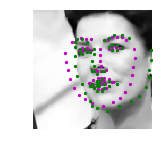

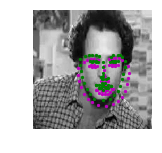

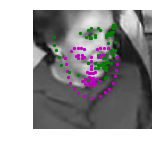

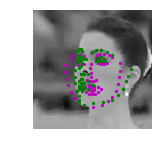

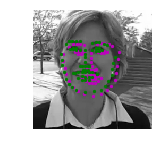

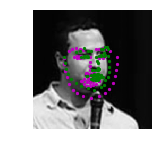

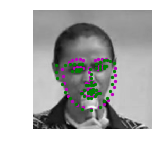

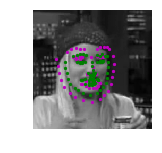

In [37]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [38]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_baseline_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

> **Optimizer**: *Adam optimizer*, since it proved the effectiveness of combining RMSProp and AdaGrad with corresponging avantages. This allows to be flexible in adjusting learning rate and handling sparce gradients (scales down if gradients become too large and scales smoothly with smaller ones). 

> **Loss function**: *MSE (Mean squared loss)*. It produces the positive result and *heavily penalizes the large mistakes of model*, resulting in bigger error. <br>
In our case this function seems to be better choice, for instance, compared to MAE, that behaves in more stochastic way, but efficiently handle outliers (not really applicable to our data set). 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

Starting model (BaseNet) consisted of Convolutional blocks, followed by batch normalisation and larger kernel size. <br>
However, in the end, the model was change since:

 * *Smaller kernel size (5x5 and less) results in better performance*, that was proved by practice.
 * *Complex models more likely lead to overfitting* (especially on training small dataset, like in our case) and requires more training, that computationally expensive. This was a reason to simplify architecture of final model.
 * *Batch normalization does not always improve performance*. For this particular problem **dropout** demonstrated much better results. 
 * *Kernel decay* on each convolutional layer along with *increasing dropout rate* were adopted from [NaimishNet paper](https://arxiv.org/abs/1710.00977). 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

> **Number of epochs**: an optimal number is determined while training - as long as training error keeps decreasing, we process entire data set epoch by epoch, aiming to stuck in minimum.

> **Batch size**: using large batch size is computationally expensive (e.g. we calculate gradients of each sample for entire dataset), but we go faster to a local minimum. With smaller batch size we need to take more steps (each of them is less expensive), but on average we head towards the minimum. <br>
SGD usually oscillate around the minimum, hence, a tradeoff would be to apply mini-batch size (e.g. batch_size = 10). <br>
Thus, using mini-batches we can reach proper model performance in a reasonable amount of time. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.2009076  -0.25809142 -0.20374303  0.09500863 -0.18490326]
 [ 0.02951145 -0.15675119 -0.16872285 -0.1656075  -0.23121412]
 [ 0.00567117 -0.06271995  0.10850929 -0.23577252  0.04750031]
 [-0.1726048  -0.24981187  0.00867613 -0.2186166  -0.20302485]
 [-0.08797518 -0.17864518 -0.07306447  0.13622034 -0.08705727]]
(5, 5)


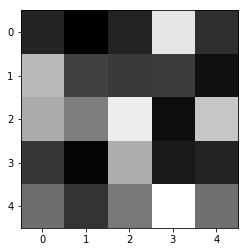

In [11]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer

# load the parameters of model we trained
state_dict = torch.load('saved_models/keypoints_baseline_model.pt')
net.load_state_dict(state_dict)

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

Text(0.5,1,'Filtered')

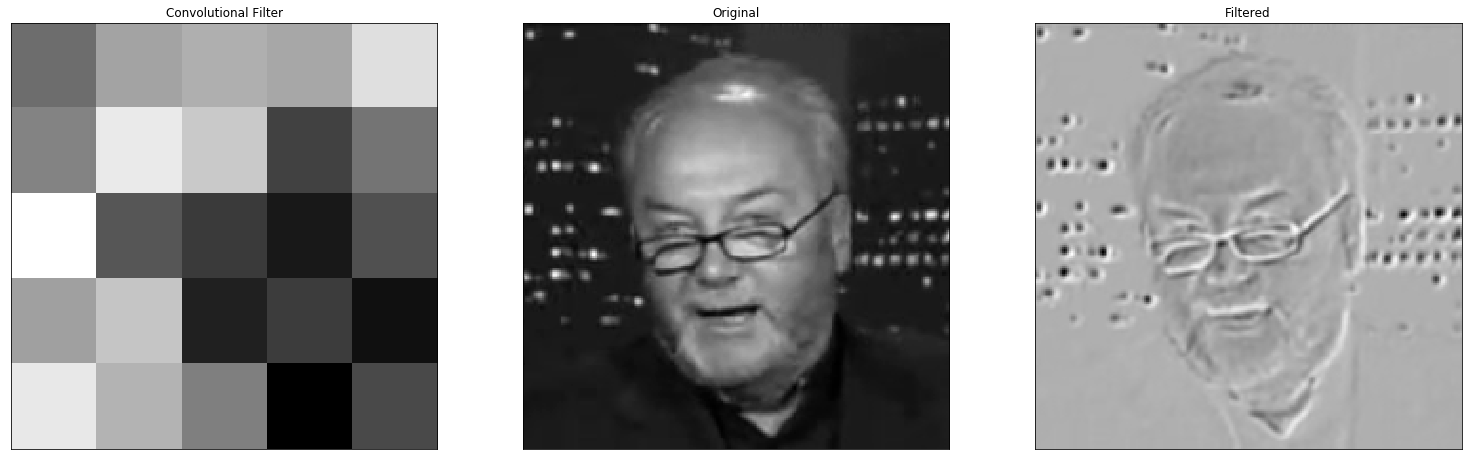

In [40]:
##### TODO: load in and display any image from the transformed test dataset
idx = 8
filter_idx = 20
example = test_images[idx].numpy()
example = example.reshape(example.shape[1:])

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# start with first convolutional filter 

import cv2

weights = net.conv1.weight.data
w = weights.numpy()

c = cv2.filter2D(example, -1, w[filter_idx][0])

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(26, 9))
plt.tight_layout()

plt.subplot(1,3,1, xticks =[], yticks =[])
plt.imshow(w[filter_idx][0], cmap='gray')
plt.title('Convolutional Filter')

plt.subplot(1,3,2, xticks =[], yticks =[])
plt.imshow(example, cmap='gray')
plt.title('Original')

plt.subplot(1,3,3, xticks =[], yticks =[])
plt.imshow(c, cmap='gray')
plt.title('Filtered')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:  This particular filter on first Convolutional layer is seemed to prevent parts with of an image *with high intensity* (masking them by turning black) and *detect edges* in places, where intensity changes rapidly e.g. glasses on the face, edges of clothes. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!